In [1]:
import pandas as pd
import shutil
from pathlib import Path


xlsx_in = Path("../data/cache2/raw/cache2-supplementary-tables-1-9-including-review-compound-and-computation-information.xlsx")

df = pd.read_excel(
    xlsx_in,
    sheet_name=1,
    header=3,
    usecols=["CACHE ID", "Smiles", "Adjusted relative 50uM [1]", "NSP13 KD (µM)", "ATPase % inhib at 50 µM [2]"]
).reset_index(drop=True)
df.columns = ["id_raw", "smiles", "Adjusted relative 50uM [1]", "NSP13 KD (µM)", "ATPase % inhib at 50 µM [2]"]
df["id"] = [f"s_{i}" for i in df.index]
df["NSP13 KD (µM)"] = (
    df["NSP13 KD (µM)"]
    .astype(str)
    .str.replace(">", "", regex=False)
    .astype(float)
)
df["binder_kd"] = df["NSP13 KD (µM)"] > 0
df["binder_adj"] = df.apply(lambda x: x['Adjusted relative 50uM [1]']>=0.4, axis=1)
df["binder_ATPase"] = df["ATPase % inhib at 50 µM [2]"].notna()
df_adj = df[["id", "binder_adj", "binder_ATPase", 'Adjusted relative 50uM [1]', "ATPase % inhib at 50 µM [2]"]]


In [2]:
df_ids = pd.read_csv(f"../data/cache2/processed/smiles.tsv", sep='\t')
df_boltz = pd.read_csv(f"../results_summary/all_hbase.tsv", sep='\t')
df_boltz.columns = ['sample', 'id', 'affinity_probability_binary']
df = df_ids.merge(df_boltz, on='id')
df['batch_size'] = df.apply(lambda x: x['sample'].split('_')[1], axis=1)

df_hbase = df.copy()
df_hbase = df_hbase.merge(df_adj, on = 'id')
df_hbase_adj = df_hbase.copy()
df_hbase_adj = df_hbase_adj[~(df_hbase_adj['binder'] & df_hbase_adj['binder_adj'])]
#df_hbase_adj = df_hbase_adj[~(df_hbase_adj['binder'] & ~df_hbase_adj['binder_ATPase'])]

df_ids = pd.read_csv(f"../data/cache2/processed/smiles.tsv", sep='\t')
df_boltz = pd.read_csv(f"../results_summary/all_hmin.tsv", sep='\t')
df_boltz.columns = ['sample', 'id', 'affinity_probability_binary']
df = df_ids.merge(df_boltz, on='id')
df['batch_size'] = df.apply(lambda x: x['sample'].split('_')[1], axis=1)

df_hmin = df.copy()
df_hmin = df_hmin.merge(df_adj, on = 'id')
df_hmin_adj = df_hmin.copy()
df_hmin_adj = df_hmin_adj[~(df_hmin_adj['binder'] & df_hmin_adj['binder_adj'])]
#df_hmin_adj = df_hmin_adj[~(df_hmin_adj['binder'] & ~df_hmin_adj['binder_ATPase'])]

df_ids = pd.read_csv(f"../data/cache2/processed/smiles.tsv", sep='\t')
df_boltz = pd.read_csv(f"../results_summary/all_hlow.tsv", sep='\t')
df_boltz.columns = ['sample', 'id', 'affinity_probability_binary']
df = df_ids.merge(df_boltz, on='id')
df['batch_size'] = df.apply(lambda x: x['sample'].split('_')[1], axis=1)

df_hlow = df.copy()
df_hlow = df_hlow.merge(df_adj, on = 'id')
df_hlow_adj = df_hlow.copy()
df_hlow_adj = df_hlow_adj[~(df_hlow_adj['binder'] & df_hlow_adj['binder_adj'])]
#df_hlow_adj = df_hlow_adj[~(df_hlow_adj['binder'] & ~df_hlow_adj['binder_ATPase'])]

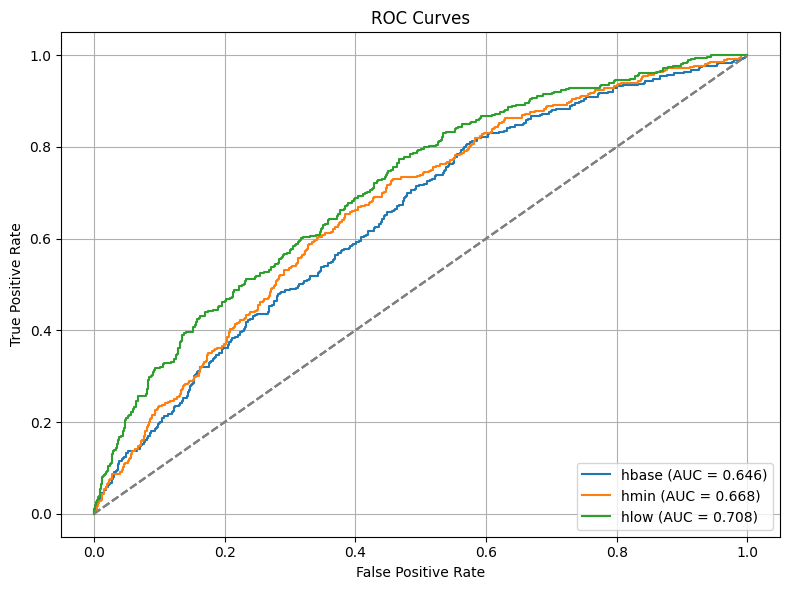

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


plt.figure(figsize=(8, 6))

y_true = df_hbase["binder"].astype(int)
y_score = df_hbase["affinity_probability_binary"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"hbase (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

y_true = df_hmin["binder"].astype(int)
y_score = df_hmin["affinity_probability_binary"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"hmin (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

y_true = df_hlow["binder"].astype(int)
y_score = df_hlow["affinity_probability_binary"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"hlow (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


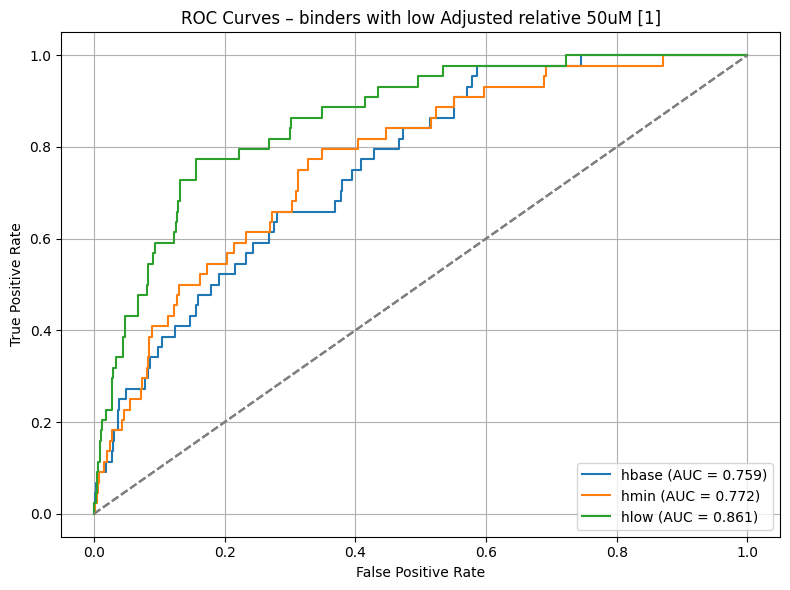

In [4]:
plt.figure(figsize=(8, 6))

y_true = df_hbase_adj["binder"].astype(int)
y_score = df_hbase_adj["affinity_probability_binary"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"hbase (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

y_true = df_hmin_adj["binder"].astype(int)
y_score = df_hmin_adj["affinity_probability_binary"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"hmin (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

y_true = df_hlow_adj["binder"].astype(int)
y_score = df_hlow_adj["affinity_probability_binary"]

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"hlow (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves – binders with low Adjusted relative 50uM [1]")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()


In [5]:
df_time = pd.read_csv('../results_summary/all_time.tsv', sep='\t')
pivot_df = df_time.pivot(index='step', columns='source', values='seconds')
pivot_df['hmin_time_reduction_percent'] = 100 * (1 - (pivot_df['all_hmin'] / pivot_df['all_hbase']))
pivot_df['hlow_time_reduction_percent'] = 100 * (1 - (pivot_df['all_hlow'] / pivot_df['all_hbase']))
pivot_df


source,all_hbase,all_hlow,all_hmin,hmin_time_reduction_percent,hlow_time_reduction_percent
step,,,,,
affinity_prediction,9515.41,1505.20,5571.94,41.442986,84.181449
structure_prediction,17563.79,6082.57,9240.51,47.388861,65.368693
